# Importing library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
%matplotlib inline


In [3]:
train = pd.read_csv('/content/drive/MyDrive/Dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Dataset/test.csv')
song = pd.read_csv('/content/drive/MyDrive/Dataset/songs.csv')
song_extra_info = pd.read_csv('/content/drive/MyDrive/Dataset/song_extra_info.csv')
members = pd.read_csv('/content/drive/MyDrive/Dataset/members.csv')

# Data Cleaning

**Train**

In [4]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   msno                object
 1   song_id             object
 2   source_system_tab   object
 3   source_screen_name  object
 4   source_type         object
 5   target              int64 
dtypes: int64(1), object(5)
memory usage: 337.7+ MB


In [6]:
train.shape

(7377418, 6)

In [7]:
train.isnull().sum()

msno                       0
song_id                    0
source_system_tab      24849
source_screen_name    414804
source_type            21539
target                     0
dtype: int64

In [8]:
train = (
    train
    .assign(
        source_system_tab=train['source_system_tab'].fillna('Unknown'),
        source_screen_name=train['source_screen_name'].fillna('Unknown'),
        source_type=train['source_type'].fillna('Unknown')
    )
)


We have a lot of null values in the train dataset, and the columns with null values have a dtype of 'category'. There is no way to fill these values using any imputing techniques, and dropping rows is not an option due to the large number of missing values. Therefore, it is better to use the placeholder 'Unknown' to fill these missing values. This approach allows us to retain the rows with missing values while still providing meaningful information.

**Test**

In [9]:
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [10]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2556790.0,1278394.5,738081.841718,0.0,639197.25,1278394.5,1917591.75,2556789.0


In [11]:
test.shape

(2556790, 6)

In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556790 entries, 0 to 2556789
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   id                  int64 
 1   msno                object
 2   song_id             object
 3   source_system_tab   object
 4   source_screen_name  object
 5   source_type         object
dtypes: int64(1), object(5)
memory usage: 117.0+ MB


In [13]:
test.isnull().sum()

id                         0
msno                       0
song_id                    0
source_system_tab       8442
source_screen_name    162883
source_type             7297
dtype: int64

In [14]:
test = (
    test
    .assign(
        source_system_tab=test['source_system_tab'].fillna('Unknown'),
        source_screen_name=test['source_screen_name'].fillna('Unknown'),
        source_type=test['source_type'].fillna('Unknown')
    )
)


**Song**

In [15]:
song.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [16]:
len(song['genre_ids'].unique())

1046

In [17]:
song.shape

(2296320, 7)

In [18]:
song.describe().T

,count,mean,std,min,25%,50%,75%,max
song_length,2296320.0,246993.494997,160920.020019,185.0,183600.0,226627.0,277269.0,12173850.0
language,2296319.0,32.377995,24.332414,-1.0,-1.0,52.0,52.0,59.0


In [19]:
song.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   song_id      object 
 1   song_length  int64  
 2   genre_ids    object 
 3   artist_name  object 
 4   composer     object 
 5   lyricist     object 
 6   language     float64
dtypes: float64(1), int64(1), object(5)
memory usage: 122.6+ MB


In [20]:
song.isnull().sum()

song_id              0
song_length          0
genre_ids        94116
artist_name          0
composer       1071358
lyricist       1945306
language             1
dtype: int64

In [21]:
song = (
    song
    .assign(
        genre_ids=song['genre_ids'].fillna('Unknown'),
        composer=song['composer'].fillna('Unknown'),
        lyricist=song['lyricist'].fillna('Unknown'),
        language = song['language'].fillna(0)
    )
)


**song_extra_info**

In [22]:
song_extra_info.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [23]:
song_extra_info.shape

(2295971, 3)

In [24]:
song_extra_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2295971 entries, 0 to 2295970
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   song_id  object
 1   name     object
 2   isrc     object
dtypes: object(3)
memory usage: 52.6+ MB


In [25]:
song_extra_info.isnull().sum()

song_id         0
name            3
isrc       136548
dtype: int64

**Members**

In [26]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [27]:
members.shape

(34403, 7)

In [28]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   msno                    34403 non-null  object
 1   city                    34403 non-null  int64 
 2   bd                      34403 non-null  int64 
 3   gender                  14501 non-null  object
 4   registered_via          34403 non-null  int64 
 5   registration_init_time  34403 non-null  int64 
 6   expiration_date         34403 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.8+ MB


In [29]:
members.isnull().sum()

msno                          0
city                          0
bd                            0
gender                    19902
registered_via                0
registration_init_time        0
expiration_date               0
dtype: int64

In [30]:
members[members['gender'].isna()]

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613
...,...,...,...,...,...,...,...
34397,9atvTKXo3kVao2jCDpsRDBmwXEMREmDTj3o9BQWEDQk=,15,31,NaN,3,20130806,20180214
34398,Wwd/cudKVuLJ3txRVxlg2Zaeliu+LRUfiBmfrnxhRCY=,1,0,NaN,7,20131111,20170910
34400,IMaPMJuyN+ip9Vqi+z2XuXbFAP2kbHr+EvvCNkFfj+o=,1,0,NaN,7,20130802,20170908
34401,WAnCAJjUty9Stv8yKtV7ZC7PN+ilOy5FX3aIJgGPANM=,1,0,NaN,7,20151020,20170920


In [31]:
members = (
    members
    .assign(registration_init_time=pd.to_datetime(members['registration_init_time'], format='%Y%m%d'),
            expiration_date=pd.to_datetime(members['expiration_date'], format='%Y%m%d'),
            gender=members['gender'].fillna('Unknown'))
)


In [32]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,Unknown,7,2011-08-20,2017-09-20
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,Unknown,7,2015-06-28,2017-06-22
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,Unknown,4,2016-04-11,2017-07-12
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,Unknown,9,2015-09-06,2015-09-07
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,Unknown,4,2017-01-26,2017-06-13


## merging

In [33]:
# merge data on train
song = pd.merge(song, song_extra_info, on='song_id', how='left')
train = pd.merge(train, song, on='song_id', how='left')
train = pd.merge(train, members, on='msno', how='left')

In [34]:
# merge data on test
test = pd.merge(test, song, on='song_id', how='left')
test = pd.merge(test, members, on='msno', how='left')

In [35]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,Unknown,52.0,Good Grief,GBUM71602854,1,0,Unknown,7,2012-01-02,2017-10-05
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,Unknown,Unknown,52.0,Lords of Cardboard,US3C69910183,13,24,female,9,2011-05-25,2017-09-11
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,Unknown,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,13,24,female,9,2011-05-25,2017-09-11
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,Unknown,-1.0,Disco Africa,GBUQH1000063,13,24,female,9,2011-05-25,2017-09-11
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,Unknown,52.0,Sleep Without You,QM3E21606003,1,0,Unknown,7,2012-01-02,2017-10-05


In [36]:
train.shape

(7377418, 20)

In [37]:
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,224130.0,458,梁文音 (Rachel Liang),Qi Zheng Zhang,Unknown,3.0,愛其實很殘忍,TWUM71400047,1,0,Unknown,7,2016-02-19,2017-09-18
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library,320470.0,465,林俊傑 (JJ Lin),林俊傑,孫燕姿/易家揚,3.0,她說,TWB671005201,1,0,Unknown,7,2016-02-19,2017-09-18
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,Unknown,song-based-playlist,315899.0,2022,Yu Takahashi (高橋優),Yu Takahashi,Yu Takahashi,17.0,subarashiki nichijo,JPWP01070260,1,0,Unknown,4,2016-11-17,2016-11-24
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio,285210.0,465,U2,The Edge| Adam Clayton| Larry Mullen| Jr.,Unknown,52.0,Hold Me| Thrill Me| Kiss Me| Kill Me,GBAAN0201228,3,30,male,9,2007-07-25,2017-04-30
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio,197590.0,873,Yoga Mr Sound,Neuromancer,Unknown,-1.0,Om Yoga,ITO101121898,3,30,male,9,2007-07-25,2017-04-30


In [38]:
test.shape

(2556790, 20)

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 20 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   msno                    object        
 1   song_id                 object        
 2   source_system_tab       object        
 3   source_screen_name      object        
 4   source_type             object        
 5   target                  int64         
 6   song_length             float64       
 7   genre_ids               object        
 8   artist_name             object        
 9   composer                object        
 10  lyricist                object        
 11  language                float64       
 12  name                    object        
 13  isrc                    object        
 14  city                    int64         
 15  bd                      int64         
 16  gender                  object        
 17  registered_via          int64         
 18  re

# EDA

**1. song_length**

In [40]:
# convert song_length from ms to min
train['song_length'] =round(train['song_length'] / (1000 * 60),2)

Convert song_length from milliseconds to minutes for increased readability

In [41]:
# Set display options to show 2 decimal places
pd.set_option('display.float_format', '{:.2f}'.format)
train['song_length'].describe()

count   7377304.00
mean          4.09
std           1.12
min           0.02
25%           3.58
50%           4.03
75%           4.54
max         180.86
Name: song_length, dtype: float64

In [42]:
train['song_length'].isnull().sum()

114

In [43]:
train=train.dropna()

In [44]:
test['song_length'] =round(test['song_length'] / (1000 * 60),2)
test['song_length'].describe()

count   2556765.00
mean          4.06
std           1.22
min           0.02
25%           3.55
50%           3.99
75%           4.51
max         122.62
Name: song_length, dtype: float64

In [45]:
train['song_length'].isnull().sum()

0

In [46]:
test['song_length']

0         3.74
1         5.34
2         5.26
3         4.75
4         3.29
          ... 
2556785   4.13
2556786   3.28
2556787   3.55
2556788   2.74
2556789   3.86
Name: song_length, Length: 2556790, dtype: float64

**2. bd**

means age

In [47]:
train['bd'].describe()

count   6799453.00
mean         17.55
std          21.60
min         -43.00
25%           0.00
50%          21.00
75%          29.00
max        1051.00
Name: bd, dtype: float64

<Axes: ylabel='bd'>

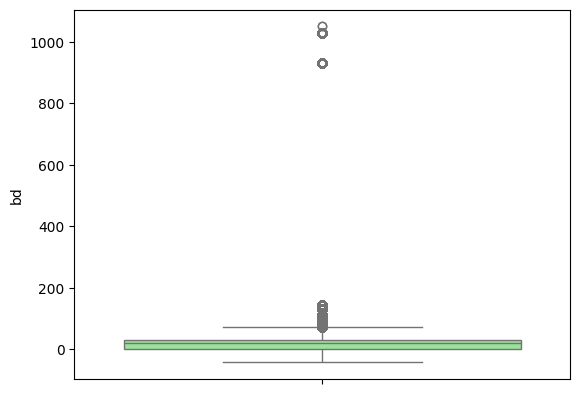

In [48]:
sns.boxplot(train['bd'],color='lightgreen')

In [49]:
train['bd'] = train['bd'].abs()
test['bd'] = train['bd'].abs()

In [50]:
# dropping age after 105
train = train[train['bd'] <= 105]
test = test[test['bd'] <= 105]

<Axes: ylabel='bd'>

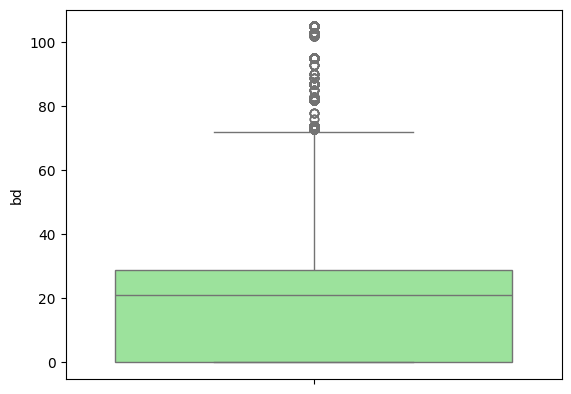

In [51]:
sns.boxplot(train['bd'], color='lightgreen')

The 'bd' column represents the age of individuals, and it contains some outliers. To address this, we first addressed negative age values by converting them to positive, assuming they were errors in data entry. We then narrowed down the age range to between 0 and 105, as the number of extreme values beyond this range was relatively small compared to the overall dataset.

We decided to retain individuals with an age of 0 despite its large count, as these individuals also had an unknown gender associated with them. This suggests that age 0 might be indicative of incomplete or missing data rather than a genuine age value.

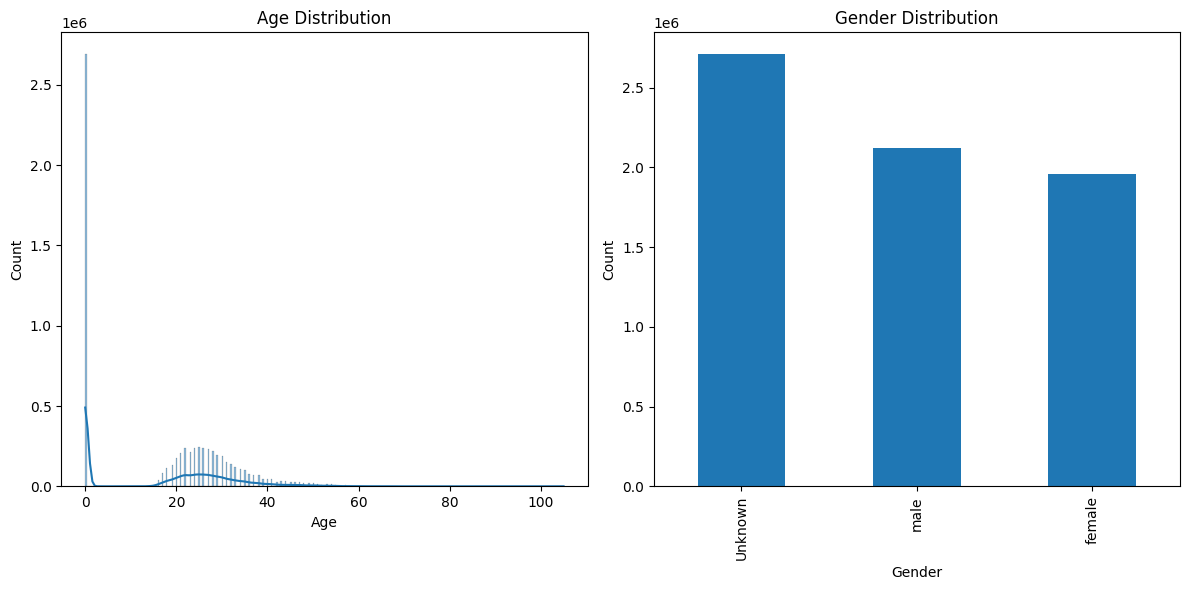

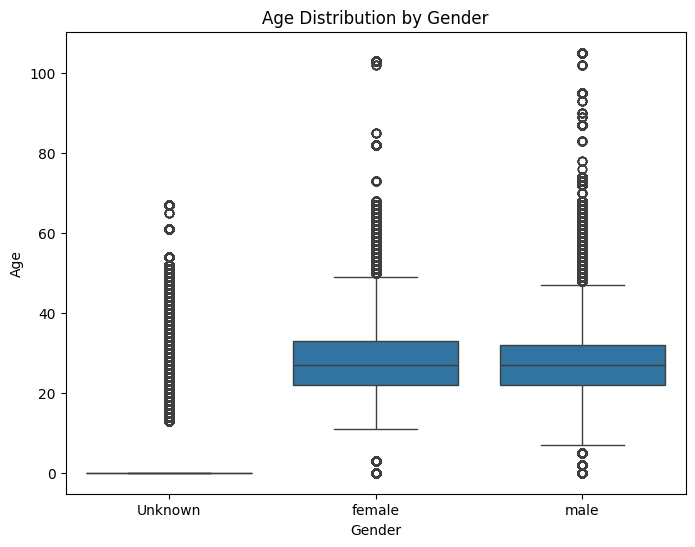

In [52]:
# Distribution of gender
gender_distribution = train['gender'].value_counts()

# Visualization
plt.figure(figsize=(12, 6))

# Age distribution
plt.subplot(1, 2, 1)
sns.histplot(train['bd'], kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')

# Gender distribution
plt.subplot(1, 2, 2)
gender_distribution.plot(kind='bar')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Box plot of age by gender
plt.figure(figsize=(8, 6))
sns.boxplot(x='gender', y='bd', data=train)
plt.title('Age Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.show()

<Axes: ylabel='count'>

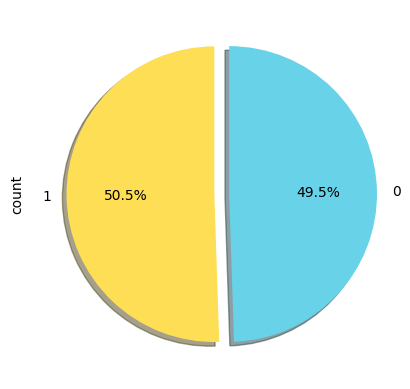

In [53]:

train['target'].value_counts().plot(kind='pie',autopct='%1.1f%%', shadow=True,explode=(0,0.1), startangle=90,colors=['#FDDE55','#68D2E8'])

The target variable is balanced

# Encoding

In [54]:
# Assuming 'train' is your train dataset
train_size = int(len(train) * 0.5)

# Sample 50% of the train data
train = train.sample(n=train_size, random_state=42)


In [55]:
# Assuming 'test' is your train dataset
test_size = int(len(test) * 0.5)
test = test.sample(n=test_size, random_state=42)


We are taking sample of dataset we have huge dataset.
The size of train dataset is 6796265 and after taking 50% the size is 3398132.
The size of test dataset is 2355900 and after taking 50% the size is 1177950

In [56]:
cat_cols = train.select_dtypes(include="O").columns
cat_cols

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'genre_ids', 'artist_name', 'composer', 'lyricist',
       'name', 'isrc', 'gender'],
      dtype='object')

In [57]:
encoder = LabelEncoder()
for col in cat_cols:
    train[col] = encoder.fit_transform(train[col])

In [58]:
encoder = LabelEncoder()
for col in cat_cols:
    test[col] = encoder.fit_transform(test[col])

In [59]:
# Dates to categoty
train['registration_init_time'] = train['registration_init_time'].astype('category')
train['expiration_date'] = train['expiration_date'].astype('category')

In [60]:
# Dates to categoty
test['registration_init_time'] = test['registration_init_time'].astype('category')
test['expiration_date'] = test['expiration_date'].astype('category')

In [61]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
x_train = train.drop(columns=['target','registration_init_time','expiration_date'])
y_train = train['target']

In [63]:
model = RandomForestClassifier(n_estimators=100, random_state=0,max_depth=20,max_features=5)

In [64]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3398132 entries, 6701842 to 3279322
Data columns (total 17 columns):
 #   Column              Dtype  
---  ------              -----  
 0   msno                int64  
 1   song_id             int64  
 2   source_system_tab   int64  
 3   source_screen_name  int64  
 4   source_type         int64  
 5   song_length         float64
 6   genre_ids           int64  
 7   artist_name         int64  
 8   composer            int64  
 9   lyricist            int64  
 10  language            float64
 11  name                int64  
 12  isrc                int64  
 13  city                int64  
 14  bd                  int64  
 15  gender              int64  
 16  registered_via      int64  
dtypes: float64(2), int64(15)
memory usage: 466.7 MB


In [65]:
model.fit(x_train, y_train)

RandomForestClassifier(max_depth=20, max_features=5, random_state=0)

In [66]:
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to store feature importances with corresponding feature names
feature_importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': feature_importances})

# Sort features by importance (descending order)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_n = 15
print("Top", top_n, "most important features:")
print(feature_importance_df.head(top_n))

Top 15 most important features:
               Feature  Importance
4          source_type        0.16
0                 msno        0.11
3   source_screen_name        0.11
2    source_system_tab        0.08
12                isrc        0.07
14                  bd        0.06
5          song_length        0.05
11                name        0.05
1              song_id        0.05
7          artist_name        0.05
8             composer        0.05
13                city        0.04
9             lyricist        0.04
6            genre_ids        0.03
16      registered_via        0.03


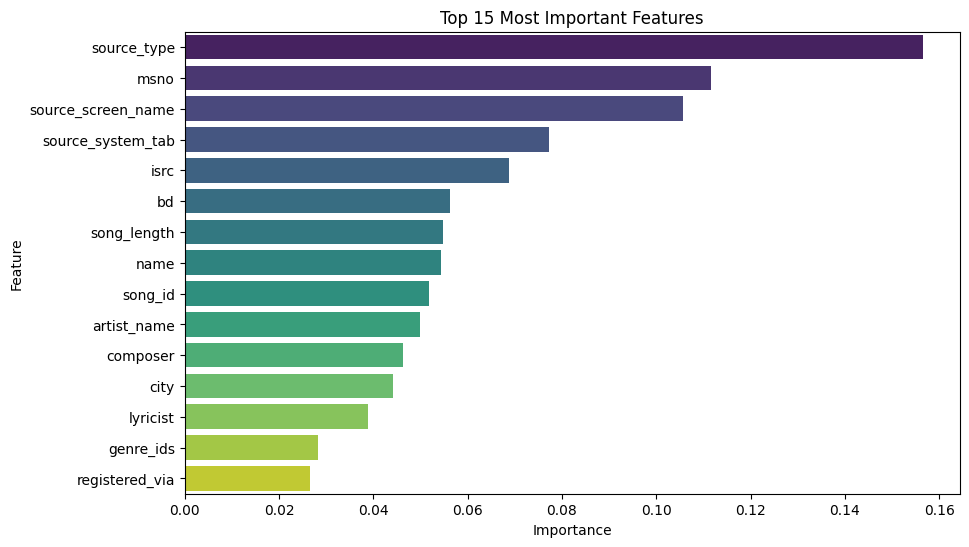

In [67]:
# Plot the top N most important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n), hue='Feature', dodge=False,palette='viridis')
plt.title('Top {} Most Important Features'.format(top_n))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.legend([], frameon=False)  # Hide legend
plt.show()


In [75]:
selected_features = feature_importance_df[feature_importance_df['Importance'] > 0.04]['Feature']

# Print the selected features
print("Selected features with importance greater than 0.4:")
print(selected_features)


Selected features with importance greater than 0.4:
4            source_type
0                   msno
3     source_screen_name
2      source_system_tab
12                  isrc
14                    bd
5            song_length
11                  name
1                song_id
7            artist_name
8               composer
13                  city
Name: Feature, dtype: object


In [82]:
# Select features with importance less than or equal to 0.04
selected_features = feature_importance_df[feature_importance_df['Importance'] <= 0.04]['Feature']

# Filter the training data to drop the selected features
train = train.drop(columns=selected_features)
train

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,artist_name,composer,name,isrc,city,bd,registration_init_time,expiration_date
6701842,15063,204408,4,8,4,1,3.15,26384,54036,131270,132661,1,0,2015-12-13,2017-09-12
6669440,17875,111734,7,0,1,0,4.52,19283,50064,10388,126312,13,28,2013-09-06,2017-10-28
6926114,10433,67382,1,11,7,0,2.32,2559,1458,80020,192836,13,24,2012-11-18,2018-08-07
3432928,17590,132786,2,7,7,0,4.15,26614,49145,119759,106602,1,0,2013-10-11,2017-09-11
1691144,23888,30791,4,8,5,1,7.47,26231,54976,104963,132259,1,0,2014-02-23,2017-09-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3615058,13180,117424,7,1,11,0,4.55,27465,33074,139313,124528,5,29,2006-12-17,2017-09-08
3526652,4072,149541,4,8,5,1,3.59,26231,53987,112344,132806,13,31,2015-08-22,2017-08-16
80056,5232,180831,4,8,4,1,3.80,11802,44572,9805,185579,1,0,2015-09-10,2017-09-09
6258581,11100,105682,4,8,5,1,3.43,8262,15578,113108,52029,13,24,2016-09-04,2017-10-01


In [84]:
test = test.drop(columns=selected_features)
test

,id,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,artist_name,composer,name,isrc,city,bd,registration_init_time,expiration_date
1851322,1851322,15113,87063,1,5,7,2.77,5290,29965,45431,103467,1,0.00,2016-08-21,2017-09-20
2172302,2172302,3120,35565,4,8,4,3.85,9632,26905,4046,111077,14,0.00,2016-03-02,2017-10-01
2354166,2354166,5833,58964,7,0,1,2.01,17063,29965,69379,34706,13,0.00,2011-11-11,2017-07-06
1418947,1418947,22557,86679,7,1,11,3.41,18085,29965,13579,116184,1,28.00,2015-11-20,2017-09-19
846550,846550,3157,69366,4,8,4,5.56,15812,37088,74800,59745,15,0.00,2012-12-17,2017-09-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704747,704747,10386,24889,7,11,7,5.23,17256,36201,80306,78915,3,27.00,2013-03-18,2018-07-31
1182100,1182100,13768,24091,7,0,1,4.35,18883,35080,103190,71160,15,0.00,2010-01-10,2017-04-29
1579828,1579828,2507,110130,1,11,7,3.61,13877,29965,108173,116184,1,0.00,2016-12-11,2017-09-11
1436863,1436863,8121,125488,4,0,1,3.92,1466,29965,34451,65788,1,59.00,2017-02-15,2017-09-15


In [92]:
X = train.drop(columns=['target',"registration_init_time","expiration_date","song_id","msno"])
y = train['target']

In [86]:
from sklearn.model_selection import train_test_split

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [94]:
print(f"Shape Of Training Data Set : ",X_train.shape)
print(f"Shape Of Testing Data Set :",X_test.shape)
print(f"Shape Of Train Label :",y_train.shape)
print(f"Shape Of Test Label :",y_test.shape)

Shape Of Training Data Set :  (2378692, 10)
Shape Of Testing Data Set : (1019440, 10)
Shape Of Train Label : (2378692,)
Shape Of Test Label : (1019440,)


# Logistic Regression

In [97]:
lr = LogisticRegression(max_iter=300,C=0.001,penalty="l2")
lr.fit(X_train,y_train)
train_pred = lr.predict(X_train)
test_pred = lr.predict(X_test)
lr_train_acc = accuracy_score(y_train,train_pred)
lr_test_acc = accuracy_score(y_test,test_pred)
print("Training Accuracy : ",lr_train_acc)
print("Test Accuracy : ",lr_test_acc)
print("Classification Report:\n",classification_report(y_train,train_pred))

Training Accuracy :  0.5182638189391481
Test Accuracy :  0.5171966962253787
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.24      0.33   1175846
           1       0.52      0.79      0.62   1202846

    accuracy                           0.52   2378692
   macro avg       0.52      0.52      0.48   2378692
weighted avg       0.52      0.52      0.48   2378692



# Naive Bayes

In [99]:
NB = GaussianNB(var_smoothing=0.01)
NB.fit(X_train,y_train)
train_pred = NB.predict(X_train)
test_pred = NB.predict(X_test)
NB_train_acc = accuracy_score(y_train,train_pred)
NB_test_acc = accuracy_score(y_test,test_pred)
print("Training Accuracy : ",NB_train_acc)
print("Test Accuracy : ",NB_test_acc)
print("Classification Report:\n",classification_report(y_train,train_pred))

Training Accuracy :  0.5176483546419629
Test Accuracy :  0.516648355960135
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.40      0.45   1175846
           1       0.52      0.64      0.57   1202846

    accuracy                           0.52   2378692
   macro avg       0.52      0.52      0.51   2378692
weighted avg       0.52      0.52      0.51   2378692



# Decision Trees

In [102]:
Dtree = DecisionTreeClassifier(max_depth=None,min_samples_leaf=1,min_samples_split=5)
Dtree.fit(X_train,y_train)
train_pred = Dtree.predict(X_train)
test_pred = Dtree.predict(X_test)
Dtree_train_acc = accuracy_score(y_train,train_pred)
Dtree_test_acc = accuracy_score(y_test,test_pred)
print("Training Accuracy : ",Dtree_train_acc)
print("Test Accuracy : ",Dtree_test_acc)
print("Classification Report:\n",classification_report(y_train,train_pred))

Training Accuracy :  0.8572417109907462
Test Accuracy :  0.5886055089068508
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.86   1175846
           1       0.87      0.84      0.86   1202846

    accuracy                           0.86   2378692
   macro avg       0.86      0.86      0.86   2378692
weighted avg       0.86      0.86      0.86   2378692



# Gradient Boosting

In [103]:
gb = GradientBoostingClassifier(learning_rate=.1,max_depth=4,n_estimators=50)
gb.fit(X_train,y_train)
train_pred = gb.predict(X_train)
test_pred = gb.predict(X_test)
gb_train_acc = accuracy_score(y_train,train_pred)
gb_test_acc = accuracy_score(y_test,test_pred)
print("Training Accuracy : ",gb_train_acc)
print("Test Accuracy : ",gb_test_acc)
print("Classification Report:\n",classification_report(y_train,train_pred))

Training Accuracy :  0.6326300336487448
Test Accuracy :  0.6326247743859373
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.64      0.63   1175846
           1       0.64      0.63      0.63   1202846

    accuracy                           0.63   2378692
   macro avg       0.63      0.63      0.63   2378692
weighted avg       0.63      0.63      0.63   2378692



# XGBoost

In [104]:
xg = xgb.XGBClassifier(random_state=0,learning_rate=.01,max_depth=3,n_estimators=50)
xg.fit(X_train,y_train)
train_pred = xg.predict(X_train)
test_pred = xg.predict(X_test)
xg_train_acc = accuracy_score(y_train,train_pred)
xg_test_acc = accuracy_score(y_test,test_pred)
print("Training Accuracy : ",xg_train_acc)
print("Test Accuracy : ",xg_test_acc)
print("Classification Report:\n",classification_report(y_train,train_pred))

Training Accuracy :  0.6225013578891256
Test Accuracy :  0.6226614611943813
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.67      0.64   1175846
           1       0.64      0.57      0.61   1202846

    accuracy                           0.62   2378692
   macro avg       0.62      0.62      0.62   2378692
weighted avg       0.62      0.62      0.62   2378692



# LightGBM

In [108]:
lgb_model = lgb.LGBMClassifier(random_state=0, learning_rate=0.01, max_depth=3, n_estimators=50)
lgb_model.fit(X_train, y_train)
train_pred = lgb_model.predict(X_train)
test_pred = lgb_model.predict(X_test)
lgb_train_acc = accuracy_score(y_train, train_pred)
lgb_test_acc = accuracy_score(y_test, test_pred)
print("Training Accuracy:", lgb_train_acc)
print("Test Accuracy:", lgb_test_acc)
print("Classification Report (Train):\n", classification_report(y_train, train_pred))


[LightGBM] [Info] Number of positive: 1202846, number of negative: 1175846
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.578044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1409
[LightGBM] [Info] Number of data points in the train set: 2378692, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505675 -> initscore=0.022703
[LightGBM] [Info] Start training from score 0.022703
Training Accuracy: 0.6225013578891256
Test Accuracy: 0.6226614611943813
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.61      0.67      0.64   1175846
           1       0.64      0.57      0.61   1202846

    accuracy                           0.62   2378692
   macro avg       0.62      0.62      0.62   2378692
weighted avg       0.62      0.62      0.62   2378692



In [110]:
cols = [
    ["Logistic Regression",lr_train_acc,lr_test_acc],
    ["Naive Bayes",NB_train_acc,NB_test_acc],
    ["Decision Trees",Dtree_train_acc,Dtree_test_acc],
    ["Gradient Boosting",gb_train_acc,gb_test_acc],
    ["XGBoost",xg_train_acc,xg_test_acc],
    ['LightGBM',lgb_train_acc,lgb_test_acc]
    ]
results = pd.DataFrame( cols,
                       columns = ["Model","Training Accuracy %","Test Evaluation %"]).sort_values(by="Test Evaluation %",ascending=False)
results.style.background_gradient(cmap='Set1')

,Model,Training Accuracy %,Test Evaluation %
3,Gradient Boosting,0.632630,0.632625
4,XGBoost,0.622501,0.622661
5,LightGBM,0.622501,0.622661
2,Decision Trees,0.857242,0.588606
0,Logistic Regression,0.518264,0.517197
1,Naive Bayes,0.517648,0.516648


In [114]:
test_df = X_test.reset_index()
test_df.head()

,index,source_system_tab,source_screen_name,source_type,song_length,artist_name,composer,name,isrc,city,bd
0,4112916,1,11,10,4.73,27443,54768,126011,106846,1,0
1,2473788,4,8,5,3.98,413,50679,135376,118939,20,25
2,6550127,4,19,11,3.40,8246,42288,7867,114955,9,44
3,4066902,4,8,5,4.41,26459,50838,121608,132727,12,0
4,2774159,1,0,1,5.05,5840,11342,90992,22383,1,0


In [115]:
predictions = gb.predict(pd.DataFrame(X_test).values)
sub = pd.DataFrame()
sub['id'] = test_df['index']
sub['target'] = predictions
sub.to_csv('submission.csv',index=False)
sub.head()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


,id,target
0,4112916,0
1,2473788,1
2,6550127,0
3,4066902,1
4,2774159,0
